# Experimentos con clasificadores para características manuales
## Adrián Arnaiz
Realizaremos diferentes modelos con diferentes comparadores sobre todos los sets de características que hemos obtenido de manera 'manual' (Disvoice). Realizaremos una comparación para ver cuales nos aportan mejores resultados.

Realizados experimentos con características extraídas directamente de DISVOICE.
> * **Sin añadir edad o sexo al conjunto de atributos.**
> * **Sin estratificar la cross Validation por edad y sexo.** 
> * **Sin dividir los conjuntos de datos por edad o sexo.**

<a id="index"></a>
## Indice de contenido
1. [Implementación experimentador](#imp)
2. [Definición experimento](#def)
3. [Experimenter \ Estandar: Modelos por defecto](#exest)
 1. [Accuracy - atribs. por defecto](#acudef)
 2. [Accuracy - atribs. normalizados](#acunorm)
 3. [AUC - atribs. por defecto](#aucdef)
 4. [Accuracy - atribs. normalizados](#aucnorm)
4. [Grid-Search \ SVM $\rightarrow$ Orozco](#gssvm)
5. [Grid-Search \ PCA - SVM](#gspca)
6. [Grid-Search \ AdaBoost](#gsada)
7. [Selección atributos](#sel)
 1. [Variance Treshold](#vtres)
 2. [Grid-Search \ KBest - AdaBoost](#skbest)
 3. [SKBest - Varios algoritmos](#skbest2) 


## 1 - Implementación de experimentador <a id="imp"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
Implementamos las funciones neccsarias para realizar un experimentador en python. Para ello seguiremos la estructura realizada en las prácticas de minería de datos realizando algunas modificaciones.

**Metricas para nuestro experimento (Clasificación) = https://scikit-learn.org/stable/modules/model_evaluation.html** (accuracy, recall, roc_auc...)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from cargaDatos import *
import cargaDatos
from experimenter import *
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import SCORERS, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
import importlib
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')



In [2]:
def get_datos_generales(experimento):
    general = experimento["GENERAL"]
    return general["ID"], general["N_FOLDS"]


def get_datasets(experimento, norm=False):
    data_nombre = [entry["ID_DATA"] for entry in experimento["DATASETS"]]
    datos_X = []
    datos_Y = []
    for dataset in experimento["DATASETS"]:
        datos = eval(dataset["ORIGIN"]+"()")
        if norm:
            X = datos.data
            sc = MinMaxScaler()
            X_sc = sc.fit(X).transform(X)
            datos_X.append(X_sc)
        else:
            datos_X.append(datos.data)
        datos_Y.append(datos.target)
    return data_nombre,datos_X,datos_Y


def get_algoritmos(experimento):
    instancias= []
    for algo in experimento["ALGORITMOS"]:
        metodo = algo["ALGO"]
        puntos = [pos for pos, char in enumerate(metodo) if char == "."]
        modulo = importlib.import_module(metodo[:puntos[-1]]) #nombre del modulo
        clase = getattr(modulo, metodo[puntos[-1]+1:]) #nombre de la clase
        instancias.append(clase(**algo["PARAMS"]))
        
    return [alg["ID_ALG"] for alg in experimento["ALGORITMOS"]],instancias


def get_output_options(experimento):
    if experimento["OUTPUT"]['DISPLAY'] in ["bar","table", "line"]:
        return experimento["OUTPUT"]['METRIC'],experimento["OUTPUT"]['DISPLAY']
    else:
        print("El modelo de representación debe ser table, line o bar")



def cross_validate_model(X,y,model,num_folds,score):
    if score not in SCORERS.keys():
        raise AttributeError("Atributo score debe ser válido. Ver válidos en sklearn.metrics.SCORERS.keys()")
    print('\t'+str(model)[:20], end=' - ')
    mod_scores = cross_val_score(model,X,y,cv=num_folds,scoring=score)
    print('FM')
    return np.array(mod_scores)

def cross_validate_all_models(data_X,data_y,models,num_folds,score):
    res_exp = []
    for d in range(len(data_names)):
        print(str(d)+' ⟶ '+data_names[d])
        dx = data_X[d]
        dy = data_y[d]
        clone_models = [clone(m) for m in models]
        res_dtset = [cross_validate_model(dx,dy,modl,num_folds,score) for modl in clone_models]
        res_exp.append(np.array(res_dtset))    
        print('Fin Data')
    print('-------------Fin Experimentos-----------')
    return res_exp


def process_results(all_results, data_names, model_names, rep_type):
    
    # los datos son inventados, no tiene porque devolver los datos de ejemplo
    data = [np.mean(res, axis=1) for res in all_results] 
    data.append(np.mean(data,axis=0))
    df = pd.DataFrame(data,
                  columns = model_names,
                  index = data_names+['MEDIA']) 
    if rep_type == "table":
        return df
    else:
        df.plot(kind=rep_type, ylim=(0,1), figsize=(18,9)).legend(bbox_to_anchor=(1.2, 0.5))


## 2 - Definición Experimento <a id="def"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [3]:
general = {
    "ID":"ExperimentoBase",
    "N_FOLDS":10
}

datasets = [
    {
        "ID_DATA":"art_rt",
        "ORIGIN":"load_art_rt",
    },
    {
        "ID_DATA":"art_w_atleta",
        "ORIGIN":"load_art_w_atleta",
    },
    {
        "ID_DATA":"art_w_braso",
        "ORIGIN":"load_art_w_braso",
    },
    {
        "ID_DATA":"art_w_campana",
        "ORIGIN":"load_art_w_campana",
    },
    {
        "ID_DATA":"art_w_gato",
        "ORIGIN":"load_art_w_gato",
    },
    {
        "ID_DATA":"art_w_petaka",
        "ORIGIN":"load_art_w_petaka",
    },
    {
        "ID_DATA":"fon_rt",
        "ORIGIN":"load_fon_rt",
    },
    {
        "ID_DATA":"fon_v_A",
        "ORIGIN":"load_fon_v_A",
    },
    {
        "ID_DATA":"fon_v_E",
        "ORIGIN":"load_fon_v_E",
    },
    {
        "ID_DATA":"fon_v_I",
        "ORIGIN":"load_fon_v_I",
    },
    {
        "ID_DATA":"fon_v_O",
        "ORIGIN":"load_fon_v_O",
    },
    {
        "ID_DATA":"fon_v_U",
        "ORIGIN":"load_fon_v_U",
    },
    {
        "ID_DATA":"fon_w_atleta",
        "ORIGIN":"load_fon_w_atleta",
    },
    {
        "ID_DATA":"fon_w_braso",
        "ORIGIN":"load_fon_w_braso",
    },
    {
        "ID_DATA":"fon_w_campana",
        "ORIGIN":"load_fon_w_campana",
    },
    {
        "ID_DATA":"fon_w_gato",
        "ORIGIN":"load_fon_w_gato",
    },
    {
        "ID_DATA":"fon_w_petaka",
        "ORIGIN":"load_fon_w_petaka",
    },
    {
        "ID_DATA":"prs_rt",
        "ORIGIN":"load_prs_rt",
    }

]

algoritmos = [
    {
        "ID_ALG":"KNN8",
        "ALGO": "sklearn.neighbors.KNeighborsClassifier",
        "PARAMS":{
            "n_neighbors":8,
            "metric":"euclidean"
        }
    },
    {
        "ID_ALG":"Tree",
        "ALGO": "sklearn.tree.DecisionTreeClassifier",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"Bayes",
        "ALGO": "sklearn.naive_bayes.GaussianNB",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"SVM",
        "ALGO": "sklearn.svm.SVC",
        "PARAMS":{
        }
    },
    {
        "ID_ALG":"RandomF",
        "ALGO": "sklearn.ensemble.RandomForestClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"Ada",
        "ALGO": "sklearn.ensemble.AdaBoostClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"Reglas",
        "ALGO": "sklearn.dummy.DummyClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"GBC",
        "ALGO": "sklearn.ensemble.GradientBoostingClassifier",
        "PARAMS":{ 
        }
    },
    
]

output = {
    "METRIC":"accuracy",
    "DISPLAY":"table"
}

experimento = {
    "GENERAL":general,
    "DATASETS":datasets,
    "ALGORITMOS":algoritmos,
    "OUTPUT": output    
}

## 3 - Ejecución Experimento Estandar: Modelos por defecto <a id="exest"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
### Accuracy - Atributos sin modificar <a id="acudef"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [5]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.420000,0.600000,0.650000,0.500000,0.680000,0.700000,0.510000,0.720000
art_w_atleta,0.660000,0.500000,0.590000,0.500000,0.570000,0.610000,0.530000,0.580000
art_w_braso,0.510000,0.580000,0.640000,0.520000,0.540000,0.520000,0.550000,0.590000
art_w_campana,0.570000,0.530000,0.640000,0.480000,0.590000,0.650000,0.520000,0.630000
art_w_gato,0.520000,0.520000,0.640000,0.520000,0.590000,0.600000,0.570000,0.630000
art_w_petaka,0.510000,0.560000,0.650000,0.470000,0.530000,0.610000,0.540000,0.670000
fon_rt,0.560000,0.570000,0.590000,0.430000,0.570000,0.750000,0.530000,0.640000
fon_v_A,0.653333,0.580000,0.640000,0.573333,0.633333,0.650000,0.526667,0.643333
fon_v_E,0.593333,0.566667,0.650000,0.553333,0.606667,0.590000,0.486667,0.606667
fon_v_I,0.590000,0.596667,0.633333,0.586667,0.636667,0.613333,0.523333,0.613333


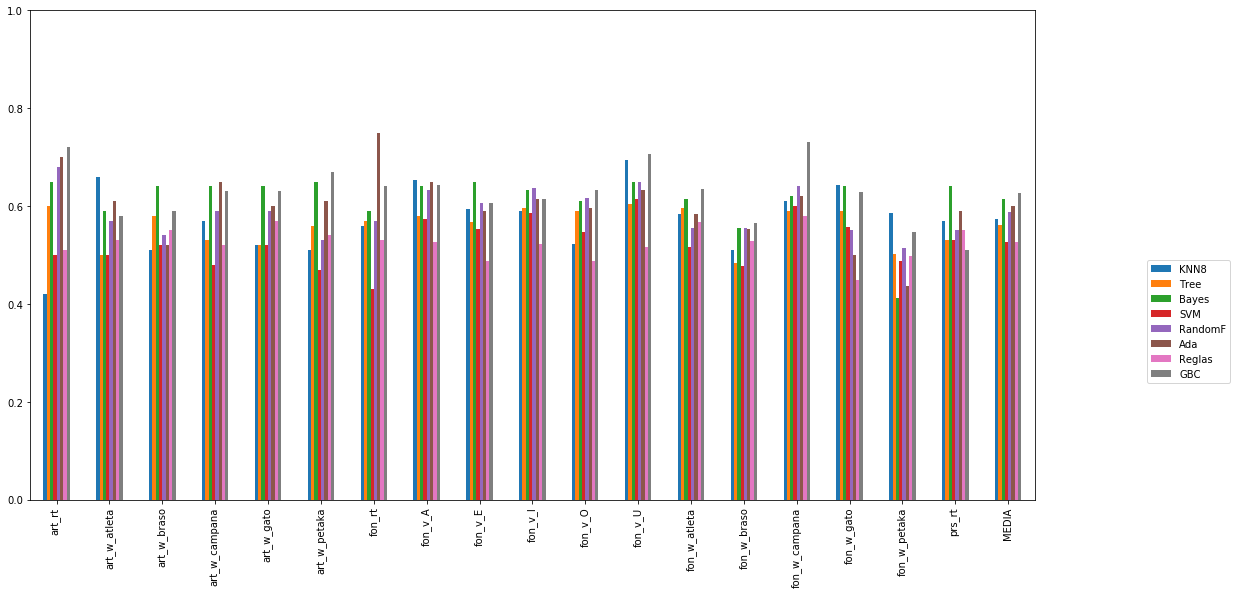

In [6]:
rep_type = "bar"
process_results(all_results, data_names, model_names, rep_type)

### Accuracy - Atributos normalizados <a id="acunorm"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [7]:
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento,True)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [8]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.590000,0.560000,0.650000,0.630000,0.630000,0.700000,0.520000,0.700000
art_w_atleta,0.600000,0.520000,0.590000,0.570000,0.660000,0.610000,0.560000,0.610000
art_w_braso,0.550000,0.560000,0.640000,0.610000,0.580000,0.520000,0.490000,0.590000
art_w_campana,0.580000,0.560000,0.640000,0.570000,0.540000,0.650000,0.560000,0.630000
art_w_gato,0.660000,0.580000,0.640000,0.640000,0.660000,0.600000,0.490000,0.650000
art_w_petaka,0.570000,0.590000,0.650000,0.590000,0.620000,0.610000,0.490000,0.720000
fon_rt,0.510000,0.600000,0.590000,0.550000,0.510000,0.750000,0.550000,0.650000
fon_v_A,0.613333,0.593333,0.640000,0.646667,0.660000,0.650000,0.463333,0.643333
fon_v_E,0.603333,0.553333,0.650000,0.646667,0.620000,0.590000,0.470000,0.603333
fon_v_I,0.590000,0.570000,0.633333,0.640000,0.583333,0.613333,0.500000,0.626667


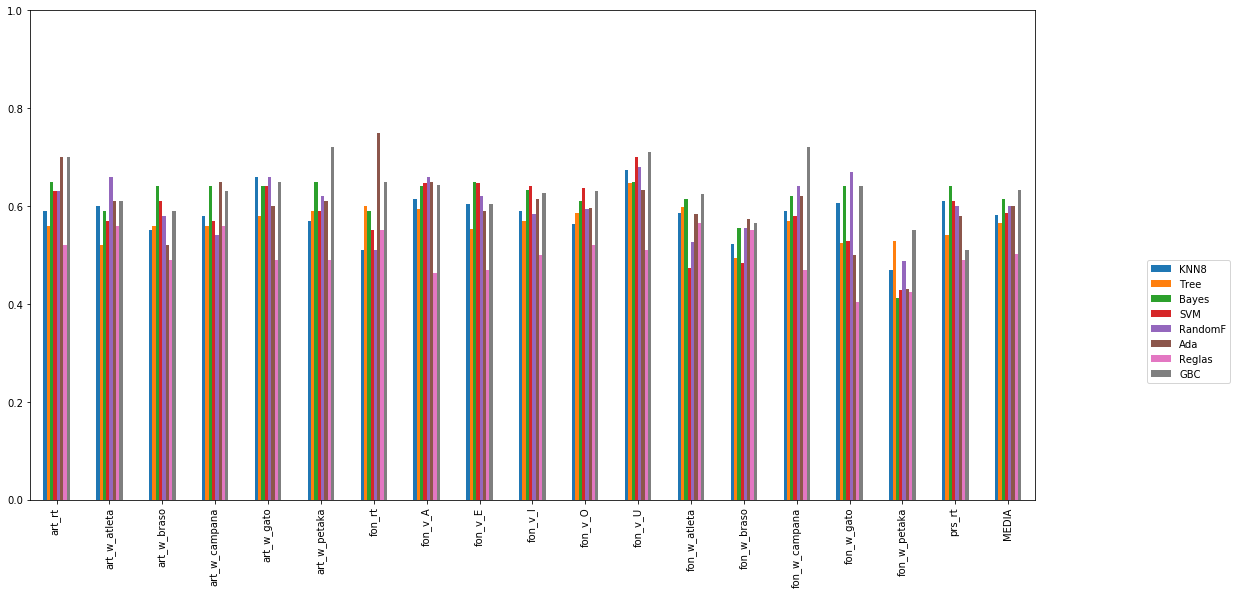

In [9]:
rep_type='bar'
process_results(all_results, data_names, model_names, rep_type)

### AUC - Atributos sin modificar <a id="aucdef"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [10]:
experimento['OUTPUT']['METRIC']='roc_auc'

In [11]:
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [12]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.474000,0.580000,0.694000,0.580000,0.626000,0.784000,0.550000,0.732000
art_w_atleta,0.696000,0.580000,0.640000,0.526000,0.614000,0.708000,0.520000,0.680000
art_w_braso,0.526000,0.580000,0.692000,0.506000,0.614000,0.536000,0.630000,0.632000
art_w_campana,0.598000,0.500000,0.682000,0.514000,0.602000,0.696000,0.530000,0.664000
art_w_gato,0.572000,0.540000,0.672000,0.408000,0.678000,0.616000,0.500000,0.708000
art_w_petaka,0.562000,0.550000,0.716000,0.544000,0.598000,0.632000,0.520000,0.720000
fon_rt,0.542000,0.570000,0.592000,0.416000,0.702000,0.836000,0.390000,0.688000
fon_v_A,0.644667,0.586667,0.701778,0.617111,0.683778,0.694222,0.490000,0.704444
fon_v_E,0.624222,0.553333,0.724222,0.590222,0.660444,0.634889,0.510000,0.658667
fon_v_I,0.628889,0.580000,0.682222,0.633333,0.695333,0.656444,0.493333,0.663111


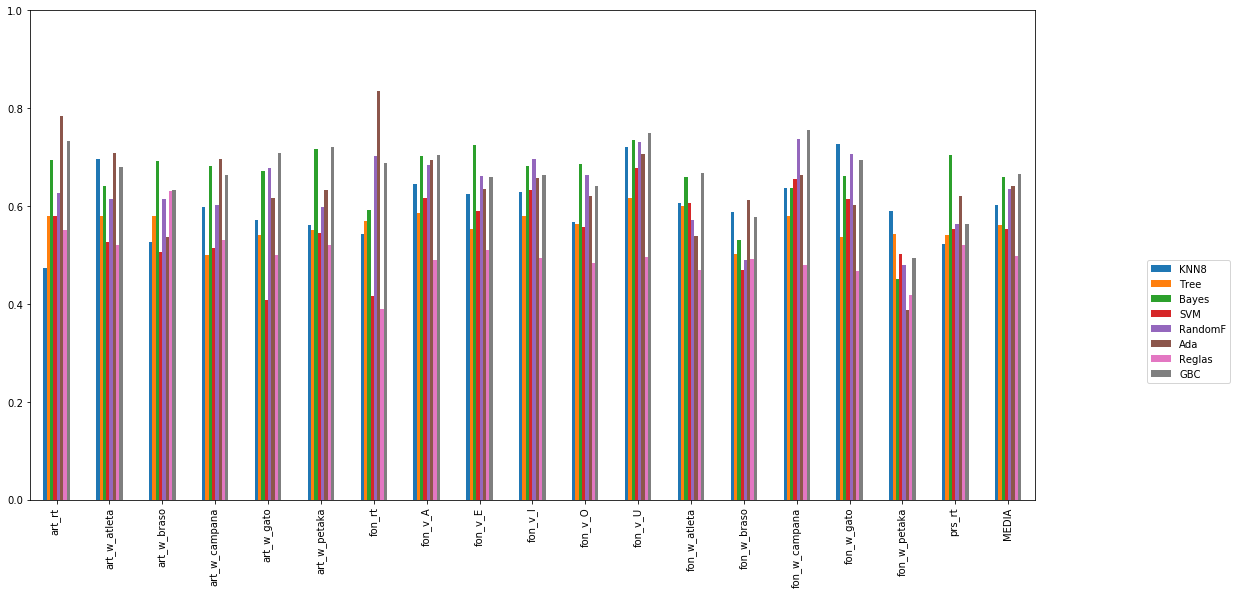

In [13]:
rep_type='bar'
process_results(all_results, data_names, model_names, rep_type)

### AUC - Atributos Normalizados <a id="aucnorm"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [14]:
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento, True)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [15]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.700000,0.610000,0.694000,0.756000,0.668000,0.784000,0.540000,0.732000
art_w_atleta,0.662000,0.530000,0.640000,0.692000,0.614000,0.708000,0.460000,0.692000
art_w_braso,0.582000,0.560000,0.692000,0.680000,0.600000,0.536000,0.530000,0.632000
art_w_campana,0.588000,0.590000,0.678000,0.700000,0.556000,0.696000,0.500000,0.652000
art_w_gato,0.736000,0.550000,0.672000,0.672000,0.674000,0.616000,0.400000,0.708000
art_w_petaka,0.620000,0.570000,0.716000,0.712000,0.646000,0.616000,0.510000,0.708000
fon_rt,0.600000,0.550000,0.592000,0.500000,0.606000,0.836000,0.450000,0.684000
fon_v_A,0.659333,0.590000,0.701333,0.727111,0.657333,0.694222,0.490000,0.716000
fon_v_E,0.631111,0.553333,0.724222,0.745778,0.668222,0.634889,0.543333,0.667556
fon_v_I,0.654000,0.610000,0.682222,0.718667,0.612000,0.656444,0.543333,0.656889


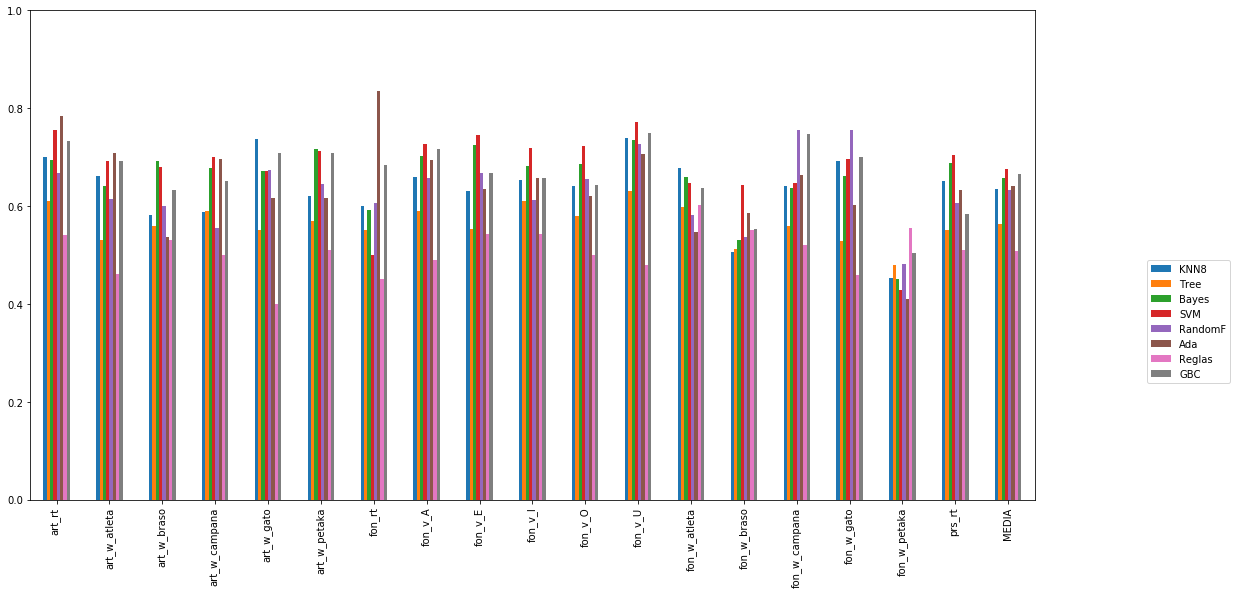

In [16]:
rep_type='bar'
process_results(all_results, data_names, model_names, rep_type)

-------------

In [17]:
experimento['OUTPUT']['METRIC']='accuracy'

## 4 - Experimento artículo 2016 Orozco: SVM con kernel gaussiano haciendo gridSearch de parámetros C y $\gamma$ realizando 10-fold cross-validation <a id="gssvm"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
#### Primero realizamos función que realizará la optimización de parámetros con GridSearch para cada uno de los diferentes conjuntos de atributos. Devuelve:
> * **mejores** = diccionario cuyas claves son el nombre de los sets de caracteristicas y contiene para cada set:
 * *score* = score del mejor conjunto de parametros para ese set de ccas.
 * *params* = parametros que consiguen el mejor score para ese conunto.
 * *results* = clf.cv_results_ para el experimento  de gridsearch de ese dataset


In [21]:
def GridSearchPipe(pipe,pg):
    mejores=dict()

    for dtst in [ d for d in dir(cargaDatos) if d.startswith('load')]:
        datos = eval(dtst+'()')
        X = datos.data
        y = datos.target
        sc = MinMaxScaler()
        X = sc.fit(X).transform(X) #Comentar para no normalizar

        clf = GridSearchCV(pipe, cv=10, param_grid=pg)
        puntuacion = cross_val_score(clf,X,y,cv=10,scoring='roc_auc') #Hacemos nested CV
        mejores[dtst[5:]]=puntuacion.mean()

        print('\n------------------------\nDataset:',dtst[5:])
        print("Score:",puntuacion.mean())  

    return mejores

#### Funcion que pasa el diccionario *mejores* a un dataframe para la mejor visualización de los reultados

In [19]:
def best_to_panda(mej):
    return pd.DataFrame.from_dict(mej, orient='index',columns=['SCORE']).sort_values(by=['SCORE'], ascending=False)

#### Realizamos el experimento de orozco. 
SVM con gridSearch de C y $\gamma$

In [22]:
param_grid = [
      {'C': [1, 10, 100, 1000, 10000], 'kernel': ['rbf'], 'gamma' : [1000,100,10,1]},
 ]

bestsOrz = GridSearchPipe(svm.SVC(),param_grid)


------------------------
Dataset: art_rt
Score: 0.592

------------------------
Dataset: art_w_atleta
Score: 0.668

------------------------
Dataset: art_w_braso
Score: 0.5959999999999999

------------------------
Dataset: art_w_campana
Score: 0.5559999999999999

------------------------
Dataset: art_w_gato
Score: 0.6599999999999999

------------------------
Dataset: art_w_petaka
Score: 0.484

------------------------
Dataset: fon_rt
Score: 0.6440000000000001

------------------------
Dataset: fon_v_A
Score: 0.6639999999999999

------------------------
Dataset: fon_v_E
Score: 0.7088888888888889

------------------------
Dataset: fon_v_I
Score: 0.6511111111111111

------------------------
Dataset: fon_v_O
Score: 0.6688888888888889

------------------------
Dataset: fon_v_U
Score: 0.7448888888888889

------------------------
Dataset: fon_w_atleta
Score: 0.6030000000000001

------------------------
Dataset: fon_w_braso
Score: 0.46925

------------------------
Dataset: fon_w_campana
Score

In [23]:
best_to_panda(bestsOrz)

,SCORE
fon_v_U,0.744889
fon_w_gato,0.731250
fon_w_campana,0.726000
fon_v_E,0.708889
prs_rt,0.692000
fon_v_O,0.668889
art_w_atleta,0.668000
fon_v_A,0.664000
art_w_gato,0.660000
fon_v_I,0.651111


**#Veo que los mean_train_score son 1 y los Mean_test_score son bajos = ¿SOBREAJUSTE?**

------------------
## 5 -   PCA - SVM / GridSearch <a id="gspca"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
GridSearch de reducción de dimensionalidad

In [24]:
param_grid = dict(reduce_dim__n_components=range(5,28,3), clf__C=[100,10,1], clf__gamma=[100,10,1])
estimators = [('reduce_dim', PCA()), ('clf', svm.SVC())]
pipSvm_pca= Pipeline(estimators)
bestsPCA_SVM = GridSearchPipe(pipSvm_pca,param_grid)


------------------------
Dataset: art_rt
Score: 0.514

------------------------
Dataset: art_w_atleta
Score: 0.6080000000000001

------------------------
Dataset: art_w_braso
Score: 0.696

------------------------
Dataset: art_w_campana
Score: 0.5200000000000001

------------------------
Dataset: art_w_gato
Score: 0.764

------------------------
Dataset: art_w_petaka
Score: 0.4760000000000001

------------------------
Dataset: fon_rt
Score: 0.6080000000000001

------------------------
Dataset: fon_v_A
Score: 0.6528888888888889

------------------------
Dataset: fon_v_E
Score: 0.6982222222222222

------------------------
Dataset: fon_v_I
Score: 0.6679999999999999

------------------------
Dataset: fon_v_O
Score: 0.6893333333333334

------------------------
Dataset: fon_v_U
Score: 0.768

------------------------
Dataset: fon_w_atleta
Score: 0.594

------------------------
Dataset: fon_w_braso
Score: 0.49024999999999996

------------------------
Dataset: fon_w_campana
Score: 0.6679999999

In [25]:
best_to_panda(bestsPCA_SVM)

,SCORE
fon_v_U,0.768000
art_w_gato,0.764000
fon_w_gato,0.702083
fon_v_E,0.698222
prs_rt,0.696000
art_w_braso,0.696000
fon_v_O,0.689333
fon_w_campana,0.668000
fon_v_I,0.668000
fon_v_A,0.652889


## 6 - AdaBoost /GS <a id="gsada"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [26]:
param_grid = dict(n_estimators=[50, 100, 200])

bestsAda = GridSearchPipe(AdaBoostClassifier(),param_grid)


------------------------
Dataset: art_rt
Score: 0.76

------------------------
Dataset: art_w_atleta
Score: 0.76

------------------------
Dataset: art_w_braso
Score: 0.5720000000000001

------------------------
Dataset: art_w_campana
Score: 0.76

------------------------
Dataset: art_w_gato
Score: 0.568

------------------------
Dataset: art_w_petaka
Score: 0.656

------------------------
Dataset: fon_rt
Score: 0.8320000000000001

------------------------
Dataset: fon_v_A
Score: 0.6608888888888889

------------------------
Dataset: fon_v_E
Score: 0.6582222222222222

------------------------
Dataset: fon_v_I
Score: 0.6399999999999999

------------------------
Dataset: fon_v_O
Score: 0.6137777777777778

------------------------
Dataset: fon_v_U
Score: 0.712

------------------------
Dataset: fon_w_atleta
Score: 0.6040000000000001

------------------------
Dataset: fon_w_braso
Score: 0.62075

------------------------
Dataset: fon_w_campana
Score: 0.676

------------------------
Dataset:

In [27]:
best_to_panda(bestsAda)

,SCORE
fon_rt,0.832000
art_rt,0.760000
art_w_atleta,0.760000
art_w_campana,0.760000
fon_v_U,0.712000
fon_w_campana,0.676000
fon_v_A,0.660889
fon_v_E,0.658222
art_w_petaka,0.656000
fon_v_I,0.640000


## 7 - Seleccion Atributos <a id="sel"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
### 7.1 Variance Treshold <a id="vtres"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [28]:
from sklearn.feature_selection import VarianceThreshold

def seleccion_atribs_pipe(selector, clsf):
    res=[]
    for dtst in [ d for d in dir(cargaDatos) if d.startswith('load')]:
        datos = eval(dtst+'()')
        X = datos.data
        y = datos.target
        sc = MinMaxScaler()
        X = sc.fit(X).transform(X) if clsf != 'AdaBoostClassifier' else X #Comentar para no normalizar
        params = 'chi2, K=19' if selector == 'SelectKBest' else ''
        params = 'threshold=(0.1)' if selector == 'VarianceThreshold' and clsf == 'AdaBoostClassifier' else ''
        estimators = [('feat_sel', eval(selector+'('+params+')')), ('clf', eval(clsf+'()'))]
        pipe = Pipeline(estimators)
        sc=cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean()
        res.append(sc)
    return res

In [29]:
df_VT = pd.DataFrame(index=[ d[5:] for d in dir(cargaDatos) if d.startswith('load')])
clasificadores = ['AdaBoostClassifier', 'GradientBoostingClassifier', 'svm.SVC', 'RandomForestClassifier']
for clf in clasificadores:
    res= seleccion_atribs_pipe('VarianceThreshold',clf)
    df_VT[clf[:7]]= pd.DataFrame(res,[ d[5:] for d in dir(cargaDatos) if d.startswith('load')],columns=[clf[:7]])
df_VT

,AdaBoos,Gradien,svm.SVC,RandomF
art_rt,0.756000,0.748000,0.756000,0.682000
art_w_atleta,0.672000,0.712000,0.692000,0.710000
art_w_braso,0.544000,0.652000,0.680000,0.618000
art_w_campana,0.692000,0.676000,0.700000,0.552000
art_w_gato,0.616000,0.692000,0.672000,0.680000
art_w_petaka,0.600000,0.712000,0.712000,0.634000
fon_rt,0.884000,0.680000,0.500000,0.576000
fon_v_A,0.689333,0.712000,0.727111,0.692222
fon_v_E,0.652000,0.653333,0.745778,0.681778
fon_v_I,0.645778,0.661778,0.718667,0.626667


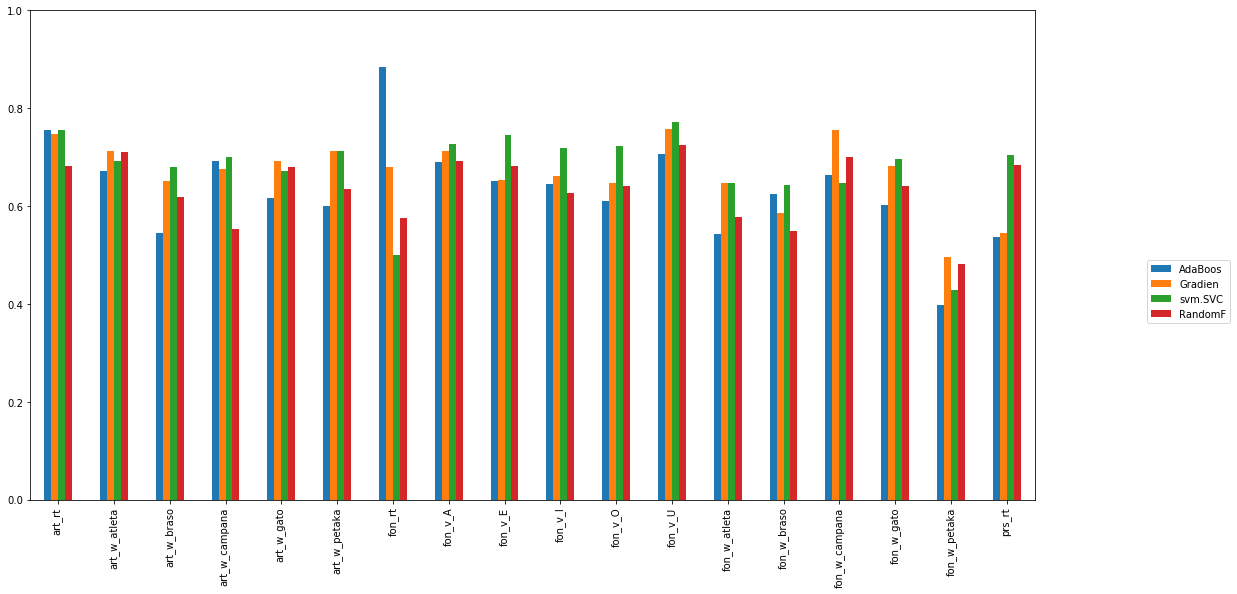

In [30]:
df_VT.plot(kind='bar', ylim=(0,1), figsize=(18,9)).legend(bbox_to_anchor=(1.2, 0.5))

### 7.2 Select K-Best - AdaBoost - GridSearch <a id="skbest"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
Se buscará el número de características óptimo den  entre 9 y 25 con el algoritmo de selección de características K-Best y el clasificador AdaBoost que es el que mejor nos está funcionando.

In [31]:
param_grid = dict(select__k=range(9,25,3))

pipe=Pipeline([('norm',MinMaxScaler()), ('select',SelectKBest(chi2, k=10)), ('clf',AdaBoostClassifier())])

bestsAda_Sk = GridSearchPipe(pipe,param_grid)


------------------------
Dataset: art_rt
Score: 0.696

------------------------
Dataset: art_w_atleta
Score: 0.5040000000000001

------------------------
Dataset: art_w_braso
Score: 0.556

------------------------
Dataset: art_w_campana
Score: 0.576

------------------------
Dataset: art_w_gato
Score: 0.6599999999999999

------------------------
Dataset: art_w_petaka
Score: 0.516

------------------------
Dataset: fon_rt
Score: 0.744

------------------------
Dataset: fon_v_A
Score: 0.6426666666666667

------------------------
Dataset: fon_v_E
Score: 0.6775555555555556

------------------------
Dataset: fon_v_I
Score: 0.6353333333333333

------------------------
Dataset: fon_v_O
Score: 0.6253333333333334

------------------------
Dataset: fon_v_U
Score: 0.7228888888888888

------------------------
Dataset: fon_w_atleta
Score: 0.561

------------------------
Dataset: fon_w_braso
Score: 0.51

------------------------
Dataset: fon_w_campana
Score: 0.644

------------------------
Dataset:

In [32]:
best_to_panda(bestsAda_Sk)

,SCORE
fon_rt,0.744000
fon_v_U,0.722889
art_rt,0.696000
fon_v_E,0.677556
prs_rt,0.668000
art_w_gato,0.660000
fon_w_campana,0.644000
fon_v_A,0.642667
fon_v_I,0.635333
fon_v_O,0.625333


### 7.3 Select K-Best <a id="skbest2"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [33]:
df_SK = pd.DataFrame(index=[ d[5:] for d in dir(cargaDatos) if d.startswith('load')])
clasificadores = ['AdaBoostClassifier', 'GradientBoostingClassifier', 'svm.SVC', 'RandomForestClassifier']
for clf in clasificadores:
    res= seleccion_atribs_pipe('SelectKBest',clf)
    df_SK[clf[:7]]= pd.DataFrame(res,[ d[5:] for d in dir(cargaDatos) if d.startswith('load')],columns=[clf[:7]])
df_SK

,AdaBoos,Gradien,svm.SVC,RandomF
art_rt,0.666000,0.628000,0.756000,0.696000
art_w_atleta,0.556000,0.572000,0.712000,0.532000
art_w_braso,0.556000,0.552000,0.640000,0.518000
art_w_campana,0.570000,0.654000,0.660000,0.678000
art_w_gato,0.542000,0.648000,0.704000,0.618000
art_w_petaka,0.536000,0.492000,0.664000,0.586000
fon_rt,0.528000,0.608000,0.472000,0.542000
fon_v_A,0.665778,0.660889,0.727111,0.684222
fon_v_E,0.674444,0.687111,0.757778,0.680667
fon_v_I,0.659556,0.667111,0.740000,0.638222


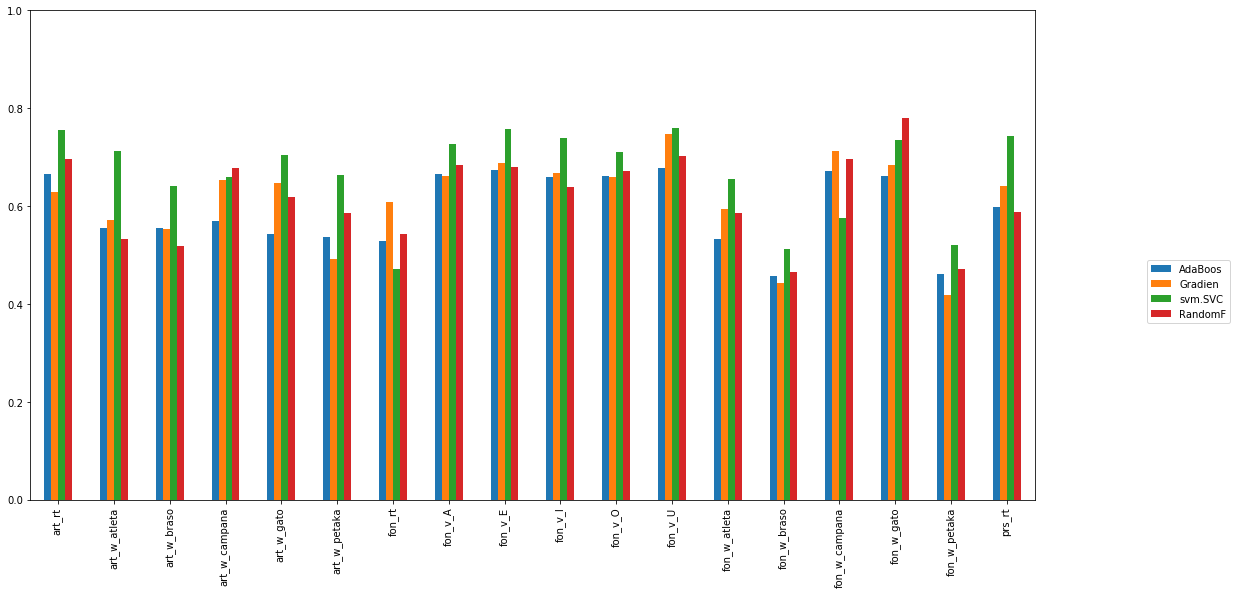

In [34]:
df_SK.plot(kind='bar', ylim=(0,1), figsize=(18,9)).legend(bbox_to_anchor=(1.2, 0.5))

## Matrices de confusión para AdaBoost

In [35]:
import seaborn as sns; sns.set()

def matrix_conf(datos):
    datos = eval(datos+'()')
    X = datos.data
    y = datos.target
    sc = MinMaxScaler()
    X = sc.fit(X).transform(X) #Comentar para no normalizar

    classifier = AdaBoostClassifier()

    # Se obtienen predicciones mediante validación cruzada 10 folds
    predicted = cross_val_predict(classifier, X, y, cv=10)

    # Se obtiene la matriz de confusión a partir de las predicciones y los valores reales
    cnf_matrix = confusion_matrix(y, predicted)

    conf_mat_df = pd.DataFrame(cnf_matrix,
                               index=['HC','PD'],
                               columns=['HC','PD'])


    return conf_mat_df


In [36]:
for dtst in [ d for d in dir(cargaDatos) if d.startswith('load')]:
    print(dtst, end='')
    tabla = matrix_conf(dtst)
    display(tabla)
    print('--------------------')
    print()

load_art_rt

,HC,PD
HC,34,16
PD,14,36


--------------------

load_art_w_atleta

,HC,PD
HC,30,20
PD,19,31


--------------------

load_art_w_braso

,HC,PD
HC,26,24
PD,24,26


--------------------

load_art_w_campana

,HC,PD
HC,32,18
PD,17,33


--------------------

load_art_w_gato

,HC,PD
HC,29,21
PD,19,31


--------------------

load_art_w_petaka

,HC,PD
HC,32,18
PD,20,30


--------------------

load_fon_rt

,HC,PD
HC,40,10
PD,15,35


--------------------

load_fon_v_A

,HC,PD
HC,104,46
PD,59,91


--------------------

load_fon_v_E

,HC,PD
HC,87,63
PD,60,90


--------------------

load_fon_v_I

,HC,PD
HC,90,60
PD,56,94


--------------------

load_fon_v_O

,HC,PD
HC,91,59
PD,62,88


--------------------

load_fon_v_U

,HC,PD
HC,104,46
PD,64,86


--------------------

load_fon_w_atleta

,HC,PD
HC,27,23
PD,18,31


--------------------

load_fon_w_braso

,HC,PD
HC,28,20
PD,23,26


--------------------

load_fon_w_campana

,HC,PD
HC,31,19
PD,19,31


--------------------

load_fon_w_gato

,HC,PD
HC,22,18
PD,20,16


--------------------

load_fon_w_petaka

,HC,PD
HC,20,28
PD,26,22


--------------------

load_prs_rt

,HC,PD
HC,29,21
PD,21,29


--------------------



## MEJOR - ADA (Sin normalizar) - VT

In [40]:
fonacion_frase = load_fon_rt()
X = fonacion_frase.data
y = fonacion_frase.target
params = dict(select__threshold=[0.01, 0.05, 0.8, 1, 0.13, 0.16, 0.2, 0.25, 0.3 ])
pip = Pipeline([('select', VarianceThreshold()), ('clf', AdaBoostClassifier())])
gs = GridSearchCV(pip,params,cv=10,scoring='roc_auc')
cross_val_score(gs,X,y,cv=10,scoring='roc_auc').mean()

0.8880000000000001

In [39]:
fonacion_frase = load_fon_rt()
X = fonacion_frase.data
y = fonacion_frase.target

sel = VarianceThreshold(threshold=(0.2))
X_r_s = sel.fit_transform(X)

ada = AdaBoostClassifier()
predicted = cross_val_predict(ada, X_r_s, y, cv=10)
score = cross_val_score(ada, X_r_s, y, cv=10, scoring='roc_auc').mean()
cnf_matrix = confusion_matrix(y, predicted)

conf_mat_df = pd.DataFrame(cnf_matrix,
                           index=['HC','PD'],
                           columns=['HC','PD'])
print('AUC =',score)
conf_mat_df

AUC = 0.8880000000000002


,HC,PD
HC,38,12
PD,9,41
